In [1]:
import sys
sys.path.append('..')
sys.path.append('../stylegan3')

import pickle, h5py

import sklearn.linear_model as linear_model
import matplotlib.pyplot as plt
import numpy as np

from stylegan_generator import StyleGANGenerator

In [2]:
_attributes = ['Attractive', 'Eyeglasses', 'No_Beard', 'Male', 'Black_Hair', 'Blond_Hair', 'Mustache', 'Young', 'Smiling', 'Bald']
_noise_path = '/home/robert/data/diploma-thesis/datasets/stylegan3/tpsi_1/latents/sample_z.h5'
_predictions_path = '/home/robert/data/diploma-thesis/predictions/stylegan3/tpsi_07/resnet34_10attr.pkl'
_feature_direction_path = 'feature_direction_inceptionv3_5attr_tanh_normalized.pkl'

network_pkl = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-1024x1024.pkl'
# network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl'
generator = StyleGANGenerator(network_pkl)

In [3]:
def find_feature_axis(z, y, method='linear', **kwargs_model):
    if method == 'linear':
        # train linear regression without transforming labels
        model = linear_model.LinearRegression(**kwargs_model)
        model.fit(z, y)
    elif method == 'tanh':
        def arctanh_clip(y):
            return np.arctanh(np.clip(y, np.tanh(0), np.tanh(3)))

        # train linear regression with labels transformed to arctanh
        model = linear_model.LinearRegression(**kwargs_model)
        model.fit(z, arctanh_clip(y))

    return model.coef_.transpose() # return transposed coeficients

def normalize_feature_axis(feature_slope):
    return feature_slope / np.linalg.norm(feature_slope, ord=2, axis=0, keepdims=True)

In [4]:
with open(_predictions_path, 'rb') as f:
    predictions = pickle.load(f)

In [5]:
with h5py.File(_noise_path, 'r') as f:
    z = f['z'][:]

(256000, 10)
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


/home/robert/miniconda3/envs/DP/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


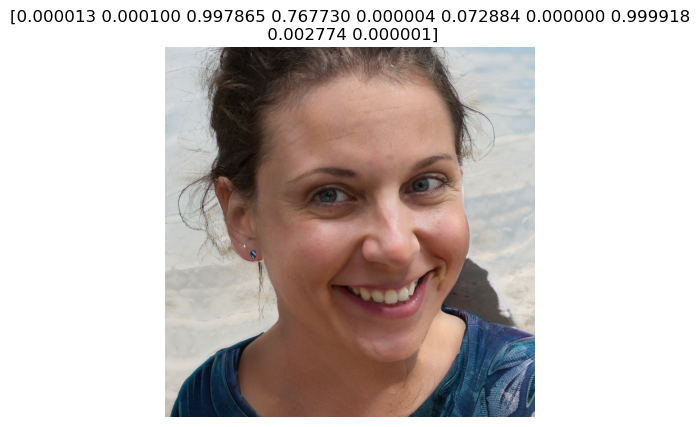

In [6]:
print(predictions.shape)

np.set_printoptions(formatter={'float_kind':"{:.6f}".format})

image_n = 5
img = generator.generate_from(np.reshape(z[image_n], (1,512)), truncation_psi=0.7)
plt.title(predictions[image_n])
plt.axis('off')
plt.imshow(img[0]/255)

In [7]:
feature_slope = find_feature_axis(z, predictions, method='tanh')

In [8]:
_normalize_feature_direction = True
if _normalize_feature_direction:
    feature_direction = normalize_feature_axis(feature_slope)
else:
    feature_direction = feature_slope

In [13]:
rnd = np.random.RandomState(123)
latents = rnd.randn(9, 512)

In [14]:
imgs1 = generator.generate_from(latents, truncation_psi=0.7)
imgs2 = generator.generate_from(latents + feature_direction[:, 1], truncation_psi=0.7)

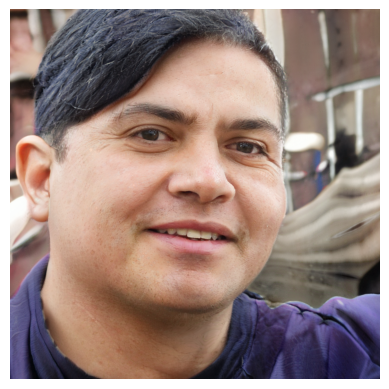

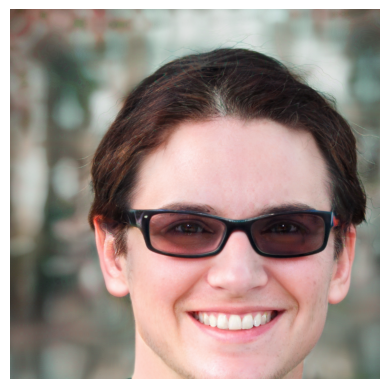

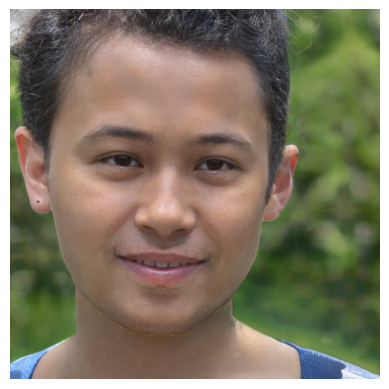

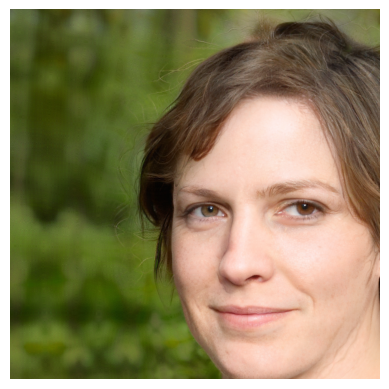

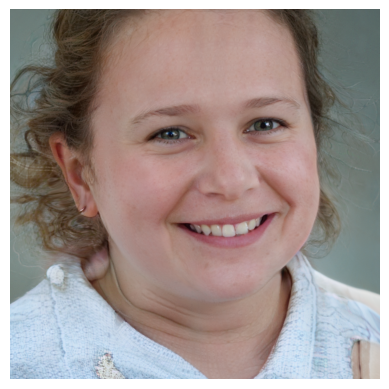

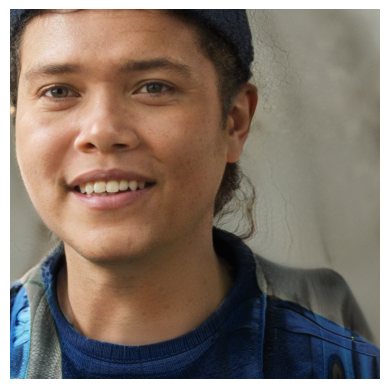

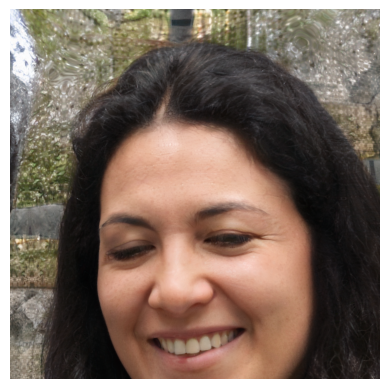

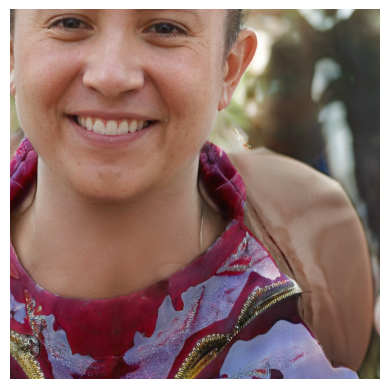

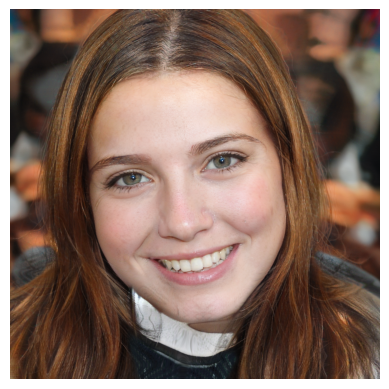

In [15]:
for img in imgs1:
    plt.axis("off")
    plt.imshow(img/255)
    plt.show()

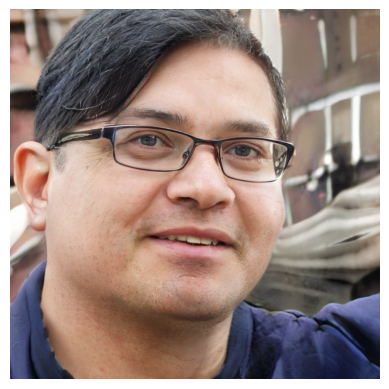

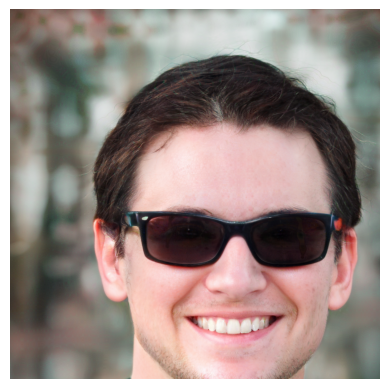

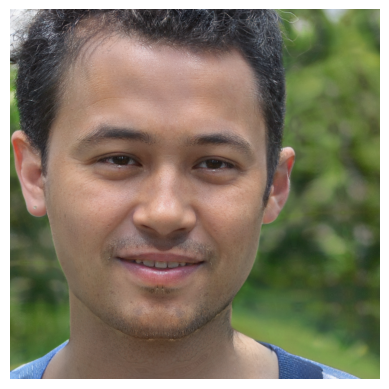

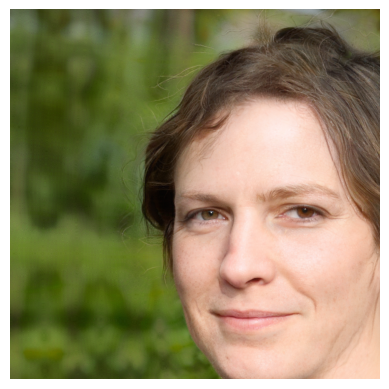

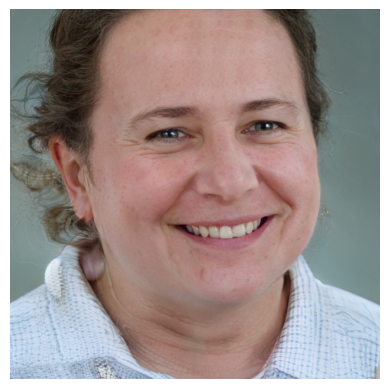

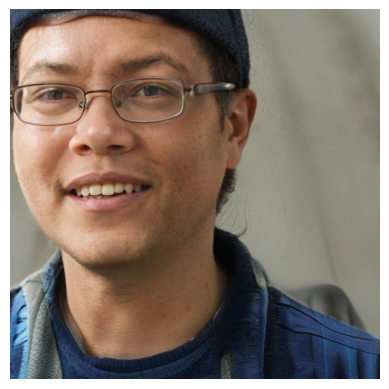

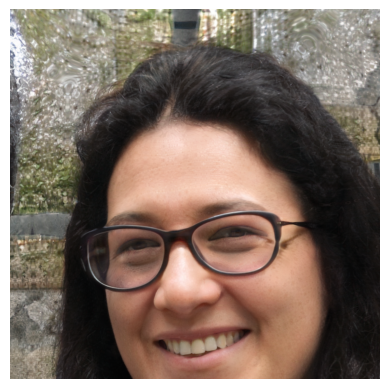

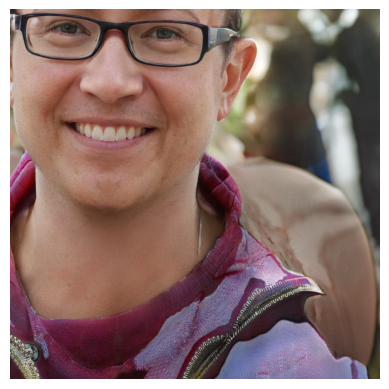

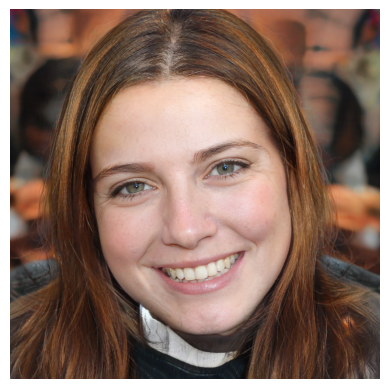

In [16]:
for img in imgs2:
    plt.axis("off")
    plt.imshow(img/255)
    plt.show()

In [19]:
print(feature_direction.shape)

(512, 10)
